In [ ]:
import sys
sys.path.append('..')
import pandas as pd
import matplotlib.pyplot as plt
import foodcosts.core as core
import datetime

In [ ]:
start_date = '2022-01-01'
end_date = '2023-02-19'

In [ ]:
def get_supplier_food_costs_period(start_date, end_date, shop = ''):
    query = """
  SELECT
    to_char(v_purchase_order.order_date, 'YYYY-MM-DD'),
    sum(total_incl_vat) from v_purchase_order
  LEFT JOIN v_supplier on v_supplier.id = v_purchase_order.supplier_id
  LEFT JOIN v_shop on v_shop.id = v_purchase_order.shop_id
  WHERE 
      v_purchase_order.order_date between '{}' and '{}' 
    """.format(start_date, end_date)
    
    if shop != '':
        query += "AND v_shop.name = ('{}')".format(shop)
    
    query += "GROUP BY v_shop.name, to_char(v_purchase_order.order_date, 'YYYY-MM-DD')"                                                
                          
    return sorted(
        [[datetime.datetime.strptime(row[0], '%Y-%m-%d'), row[1]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )

def get_atelier_food_costs_period(start_date, end_date, shop = ''):
    query = """
select 
    shop.id as shop_id,
    shop.name as shop_name,
    stats.day as date,
    sum(stats.discounted_atelier_value_sent_htva) as discounted_atelier_value_sent_htva
from v_shop_sales_statistics as stats 
left join v_shop as shop on shop.id = stats.shop_id
left join pos_order_stat_day on pos_order_stat_day.day = stats.day and (pos_order_stat_day.interval <> 'month')
where stats.day between '{}' and '{}' and discounted_atelier_value_sent_htva < 10000
    """.format(start_date, end_date)
    
    
    if shop != '':
        query += f"""AND shop.name = '{shop}'"""
    
    query += "group by shop.id,shop.name,stats.day"                                                
                              
    return sorted(
        [[row[2], row[3]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )

def get_food_costs_period(start_date, end_date, shop = ''):
    atelier = get_atelier_food_costs_period(start_date,end_date, shop=shop)
    atelier_dict = { date: amount for date,amount in atelier }
    supplier = get_supplier_food_costs_period(start_date, end_date,shop=shop)
    supplier_dict = { date.date(): amount for date,amount in supplier }
    date_range = get_date_range(start_date,end_date)
    res = []
    atelier_totals = []
    supplier_totals = []
    for date in date_range:
        
        atelier_for_date = atelier_dict[date] if date in atelier_dict else 0
        supplier_for_date = supplier_dict[date] if date in supplier_dict else 0
        
        atelier_totals.append([date, atelier_for_date])
        supplier_totals.append([date, supplier_for_date])        
        
        res.append([date, 
                    (atelier_for_date if atelier_for_date != None else 0) + 
                    (supplier_for_date if not supplier_for_date != None else 0)
                   ])
    return res

In [ ]:
def get_date_range(start_date, end_date):
    # convert the input strings to datetime objects
    start_dt = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.datetime.strptime(end_date, '%Y-%m-%d')

    # calculate the number of days between start and end, inclusive
    num_days = (end_dt - start_dt).days + 1

    # use a list comprehension to generate a list of date objects
    dates = [start_dt.date() + datetime.timedelta(days=i) for i in range(num_days)]

    return dates


In [ ]:
def run():
    start_date = '2022-01-01'
    end_date = '2022-12-31'
    return get_food_costs_period(start_date, end_date, 'LATEM')        
run()

config.ini file available... using that
config.ini file available... using that


[[datetime.date(2022, 1, 1), 0],
 [datetime.date(2022, 1, 2), Decimal('2393.30')],
 [datetime.date(2022, 1, 3), Decimal('1901.83')],
 [datetime.date(2022, 1, 4), Decimal('1750.97')],
 [datetime.date(2022, 1, 5), Decimal('2091.68')],
 [datetime.date(2022, 1, 6), Decimal('2351.82')],
 [datetime.date(2022, 1, 7), Decimal('1146.85')],
 [datetime.date(2022, 1, 8), Decimal('1260.79')],
 [datetime.date(2022, 1, 9), Decimal('2683.43')],
 [datetime.date(2022, 1, 10), Decimal('918.85')],
 [datetime.date(2022, 1, 11), Decimal('1498.36')],
 [datetime.date(2022, 1, 12), Decimal('1148.81')],
 [datetime.date(2022, 1, 13), Decimal('1672.73')],
 [datetime.date(2022, 1, 14), Decimal('1841.60')],
 [datetime.date(2022, 1, 15), Decimal('1375.06')],
 [datetime.date(2022, 1, 16), Decimal('2241.38')],
 [datetime.date(2022, 1, 17), Decimal('1488.07')],
 [datetime.date(2022, 1, 18), Decimal('2233.36')],
 [datetime.date(2022, 1, 19), Decimal('2060.74')],
 [datetime.date(2022, 1, 20), Decimal('1761.80')],
 [datet

In [ ]:
def get_sales_from_so_period(start_date, end_date, shop = ''):
    query = """
    SELECT
       v_shop.name AS shop_name, 
       DATE(v_pos_order.created_at) AS day, 
       SUM(pol.price_unit * v_pos_order_line.quantity) AS total_sales
    FROM v_pos_order_line
    LEFT JOIN pos_order_line as pol on pol.id = v_pos_order_line.id
    LEFT JOIN v_product ON v_product.id = v_pos_order_line.product_id
    LEFT JOIN v_pos_order ON v_pos_order.id = v_pos_order_line.order_id
    LEFT JOIN v_pos_session ON v_pos_session.id = v_pos_order.session_id
    LEFT JOIN v_pos ON v_pos.id = v_pos_session.pos_id
    LEFT JOIN v_shop ON v_shop.id = v_pos.shop_id
    WHERE v_pos_order.created_at BETWEEN '{}' AND '{}'
    """.format(start_date, end_date)
    
    if shop != '':
        query += f"""AND v_shop.name = '{shop}'"""
    
    query += "GROUP BY v_shop.id, v_shop.name, day"
    
    return sorted(
        [[row[1], row[2]] for row in core.make_sql_query(query)],
        key=lambda x: x[0]
    )

def get_sales_period(start_date, end_date, shop=''):
    query = """
    SELECT
        v_shop.name, 
        day,
        total
      FROM 
        v_shop_sales_statistics
      LEFT JOIN 
        v_shop on v_shop.id = v_shop_sales_statistics.shop_id
      WHERE 
        (day between '{}' and '{}')
    """.format(start_date, end_date)
    
    if shop != '':
        query += f"""AND v_shop.name = '{shop}'"""
                
    return core.make_sql_query(query)

In [ ]:
get_sales_from_so_period(core.get_yesterday(), core.get_today_date_string(), 'Woluwe')

config.ini file available... using that


[[datetime.date(2023, 3, 12), Decimal('5762.02014')]]

In [ ]:
get_sales_from_so_period??

In [ ]:
def format_datetime(dt):
    return dt.strftime("%d-%m-%Y")

def make_graph():
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('LATEM Value over Time (Cumulative)')
    return plt
    
def show_graph(graph):
    graph.show()


def add_baseline_value_to_graph(values, graph):
    dates_list = [row[1] for row in values]
    values_list = [row[2] for row in values]
    plt.plot(dates_list, values_list)    
    return dates_list
    
def add_values_to_graph(dates_list, values_list, graph):
    plt.plot(dates_list, values_list, color = 'red') 

def plot_revenue_and_foodcosts(start_date, end_date):
    graph = make_graph()
    this_year = get_sales_from_so_period(start_date, end_date, shop='LATEM')
    dates_list = add_baseline_value_to_graph(this_year, graph)
    food_costs = get_food_costs_period(start_date, end_date)
    add_values_to_graph([row[0] for row in food_costs], [row[1] for row in food_costs], graph)
    show_graph(graph)
    
def pct_costs_on_revenues(start_date, end_date, shop = '', frequency = 'M'):    
    food_costs_daily = get_food_costs_period(start_date, end_date, shop = shop)
    sales_from_so_daily = get_sales_from_so_period(start_date, end_date, shop = shop)
    num = to_series(food_costs_daily).resample(frequency).sum()
    denum = to_series(sales_from_so_daily).resample(frequency).sum()
    return divide(
        num,
        denum,       
    )

def to_series(values):
    return pd.Series([row[1] for row in values], index = pd.DatetimeIndex([row[0] for row in values]))
    
def divide(values_a, values_b):        
    res = values_a.divide(values_b, fill_value=1)
    res = res.astype(float)
    return res

In [ ]:
def run():
    food_costs_daily = get_food_costs_period(start_date, end_date, shop = 'LATEM')
    s = to_series(food_costs_daily)

In [ ]:
a = pct_costs_on_revenues('2023-02-01', '2023-02-19', shop = 'LATEM', frequency = 'W')
a

config.ini file available... using that
config.ini file available... using that
config.ini file available... using that


2023-02-05    0.495444
2023-02-12    0.589943
2023-02-19    0.499404
Freq: W-SUN, dtype: float64

In [ ]:
def plot_revenues():
    start_date = '2023-01-01'
    end_date = '2023-02-19'
    
    shops = ['Woluwe', 'LATEM']
    
    for shop in shops:
        series = to_series(get_sales_from_so_period(start_date, end_date, shop = shop)).astype(float)
        series.plot(label=shop)
        
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend(loc='best')
    plt.show()

config.ini file available... using that
config.ini file available... using that


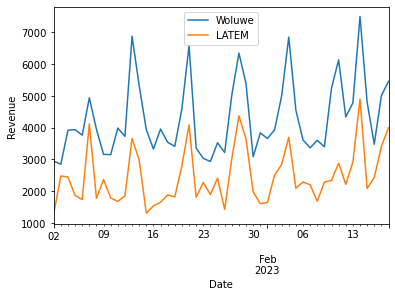

In [ ]:
plot_revenues()

In [ ]:
def plot_foodcosts():
    shops = ['Woluwe', 'LATEM']
    
    for shop in shops:
        series = to_series(get_food_costs_period(start_date, end_date, shop = shop)).astype(float)
        series.plot(label=shop)
        
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend(loc='best')
    plt.show()

config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that


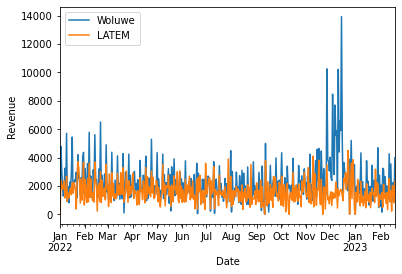

In [ ]:
plot_foodcosts()

In [ ]:
def resample_to_month(s):
    return s.resample('W').sum()

In [ ]:
def resample_to_month(s):
    return s.resample('W').sum()
    
def plot_foodcost_and_revenue_for_one_shop():
    
    shops = ['Woluwe']

    for shop in shops:
        series = resample_to_month(to_series(get_sales_from_so_period(start_date, end_date, shop = shop))).astype(float)
        series.plot(label='revenue')
        
        series_fc = resample_to_month(to_series(get_food_costs_period(start_date, end_date, shop = shop))).astype(float)
        series_fc.plot(label='foodcost')
        
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend(loc='best')
    plt.show()

config.ini file available... using that
config.ini file available... using that
config.ini file available... using that


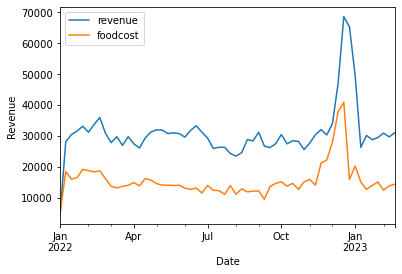

In [ ]:
plot_foodcost_and_revenue_for_one_shop()

In [ ]:
core.get_shop_names()

config.ini file available... using that


['La Hulpe',
 'Fort Jaco',
 'Woluwe',
 'Tongres',
 'Wemmel',
 'CHATELAIN',
 'OVERIJSE',
 'LATEM']

In [ ]:
def plot_pct_food_costs_on_revenues():
    # shops = core.get_shop_names()
    shops = [
        'Woluwe',
        'LATEM',
        'Fort Jaco'
    ]
    
    # define a list of colors for each bar
    colors = ['blue', 'green', 'orange']
    
    # set the width of each bar
    width = 0.25
    
    # calculate the offset for each bar
    offset = [-width, 0, width]
    
    for i, shop in enumerate(shops):
        series = pct_costs_on_revenues(start_date, end_date, shop=shop, frequency='M')
        
        # plot each bar with the corresponding color and offset
        series.plot(label=shop, 
                    color=colors[i],
#                     kind='bar', 
#                     width=width, 
#                     position=i, 
#                     stacked=False
                   )
        
    plt.xlabel('Date')
    plt.ylabel('%')
#     plt.xticks(range(len(series.index)), series.index.strftime('%Y-%m'), rotation=0)
    plt.legend(loc='best')
    plt.show()


config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that


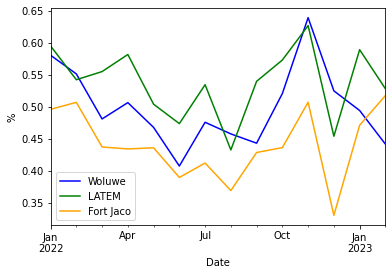

In [ ]:
plot_pct_food_costs_on_revenues()

config.ini file available... using that
config.ini file available... using that


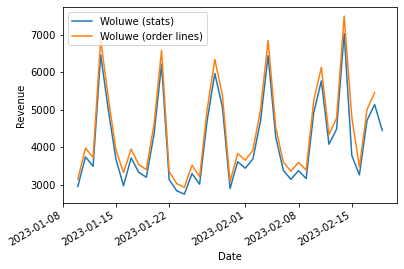

In [ ]:
def compare_pos_sales_and_stats():
    start_date = '2023-01-10'
    end_date = '2023-02-19'
    
    shops = ['Woluwe']
    
    for shop in shops:
        series = to_series(get_sales_from_so_period(start_date, end_date, shop = shop)).astype(float)
        computed_stats = core.make_sql_query("""
        SELECT 
            day
            total, 
            total_htva 
        FROM v_shop_sales_statistics
        LEFT JOIN 
            v_shop on v_shop.id = v_shop_sales_statistics.shop_id 
        WHERE v_shop.name = 'Woluwe' AND day between '{}' and '{}';
        """.format(start_date,end_date));
        computed_stats_series = to_series(computed_stats).astype(float)
        computed_stats_series.plot(label=shop + ' (stats)')
        series.plot(label=shop + ' (order lines)')
        
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend(loc='best')
    plt.show()
    
compare_pos_sales_and_stats()

In [ ]:
def compare_pos_sales_and_stats_in_table():
    start_date = '2023-01-10'
    end_date = '2023-02-19'
    
    shops = ['Woluwe']
    columns = {}
    for shop in shops:
        series = to_series(get_sales_from_so_period(start_date, end_date, shop = shop)).astype(float)
        
        computed_stats = core.make_sql_query("""
        SELECT 
            day,
            total
        FROM v_shop_sales_statistics
        LEFT JOIN 
            v_shop on v_shop.id = v_shop_sales_statistics.shop_id 
        WHERE v_shop.name = 'Woluwe' AND day between '{}' and '{}';
        """.format(start_date,end_date));
                
        computed_stats_series = to_series(computed_stats).astype(float)
        columns['from_ground_up'] = series
        columns['computed_stats'] = computed_stats_series
        
    return pd.DataFrame(columns)
    
res = compare_pos_sales_and_stats_in_table()

config.ini file available... using that
config.ini file available... using that


In [ ]:
# HTVA = Hors taxe value 
# VAT = value added tax
# tax on products. 21% for services. 6% on food

In [ ]:
res['difference'] = res.from_ground_up - res.computed_stats

<AxesSubplot:>

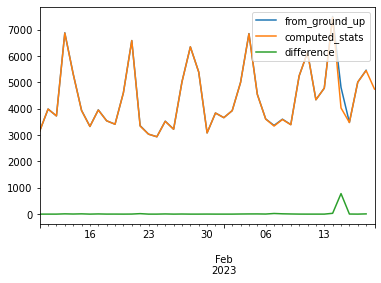

In [ ]:
res.plot()

In [ ]:
# Look at difference between stats table and ground up sum for all shops

config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that
config.ini file available... using that


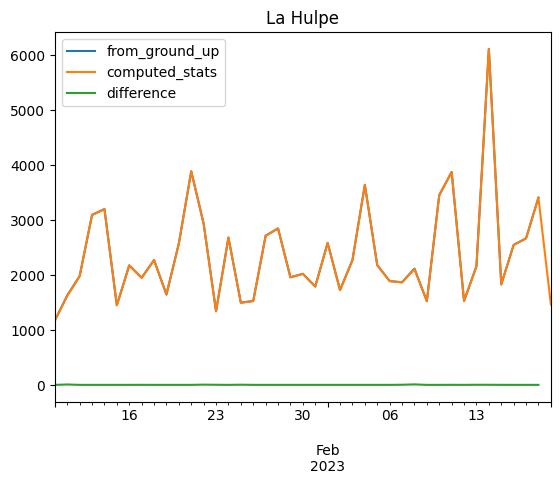

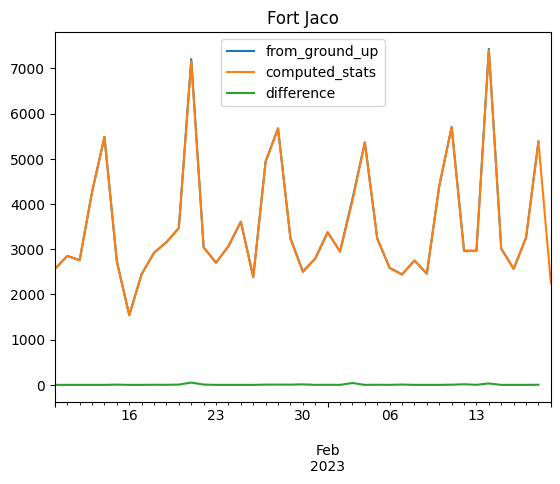

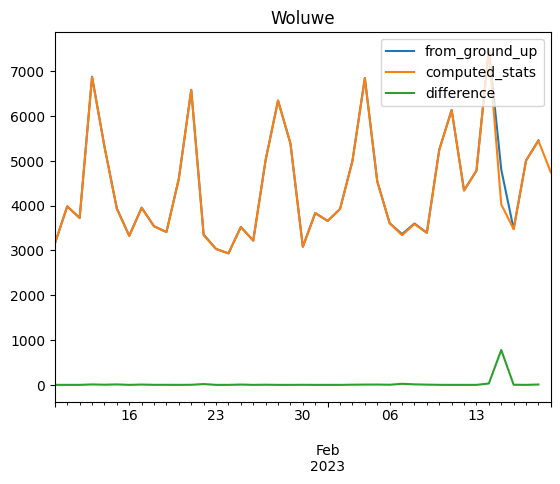

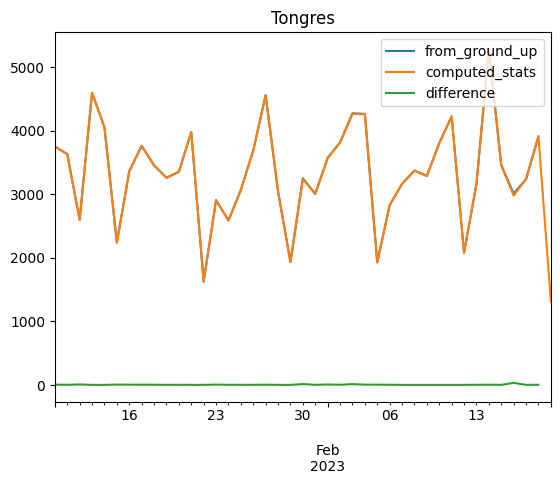

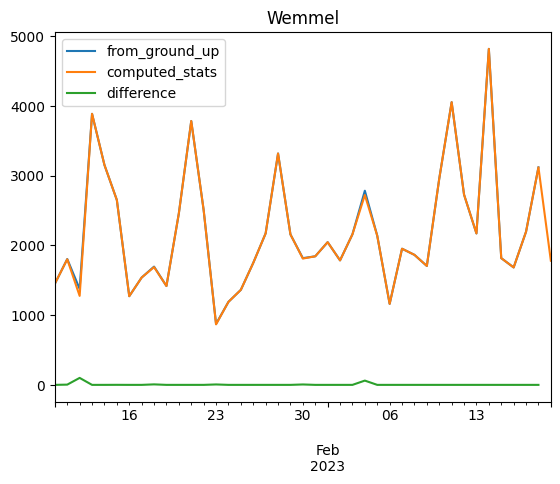

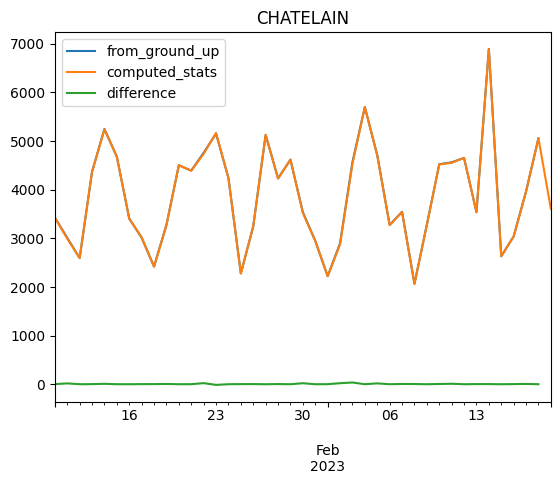

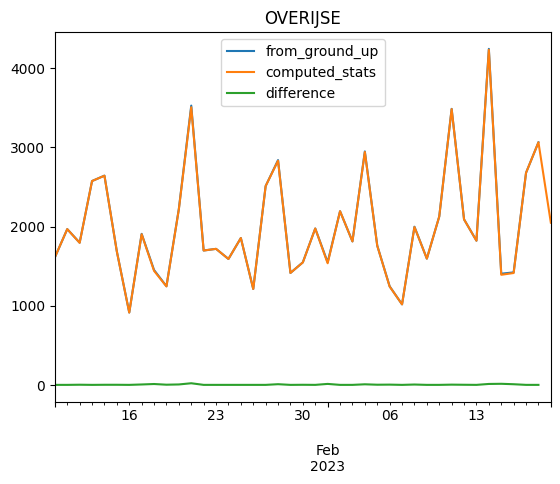

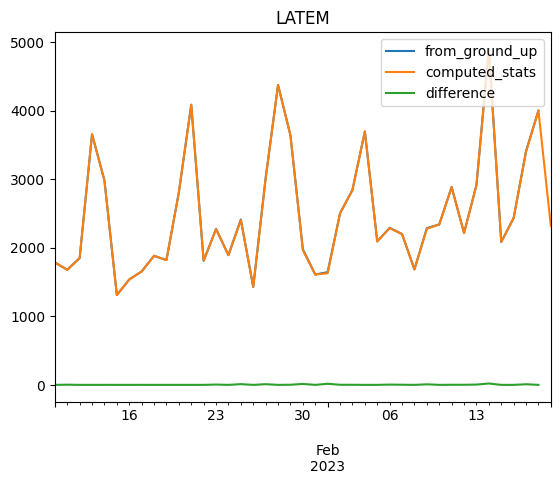

In [ ]:
def compare_pos_sales_and_stats_of_all_shop():
    start_date = '2023-01-10'
    end_date = '2023-02-19'
    shops = core.get_shop_names()
    columns = {}
    for shop in shops:
        series = to_series(get_sales_from_so_period(start_date, end_date, shop = shop)).astype(float)
        
        computed_stats = core.make_sql_query("""
        SELECT 
            day,
            SUM(total) as total
        FROM v_shop_sales_statistics
        LEFT JOIN 
            v_shop on v_shop.id = v_shop_sales_statistics.shop_id 
        WHERE v_shop.name = '{}' AND day between '{}' and '{}'
        GROUP BY v_shop_sales_statistics.day
        """.format(shop,start_date,end_date));
                
        computed_stats_series = to_series(computed_stats).astype(float)
        columns['from_ground_up'] = series
        columns['computed_stats'] = computed_stats_series
        columns['difference'] = series - computed_stats_series
        df = pd.DataFrame(columns)
        df.plot(title=shop)

compare_pos_sales_and_stats_of_all_shop()

In [ ]:
# 10 apples each apple is 2EUR >> 10 UNIT * 2 (EUR / UNIT) = 20 EUR (subtotal)
# 4  shampoos each shampoo 3EUR >> 4 UNIT * 3 (EUR / UNIT) = 12 EUR (subtotal)
# --------------
# 32 EUR (total) (discount = 2 EUR) 
